# BATCH_SIZE=1000

In [1]:
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# Import libraries
import os
import xlrd
import math
import zipfile
import numbers
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from pathlib import Path
import time
from ctgan.tablegan import TableganSynthesizer
from ctgan import CTGANSynthesizer
from ctgan import TVAESynthesizer
from sklearn.model_selection import train_test_split

In [3]:
num_epochs = 300

In [4]:
home = str(Path.home())

In [5]:
home

'C:\\Users\\stazt'

In [6]:
# Load cleaned 2016-2018 OVS datasets; replace NAs by -1
OVS1618 = pd.read_csv(home + '/Documents/nBox/Project Ultron/Milestone 3/Dataset/Cleaned (Outliers Removed)/Reduced to Benchmarks-1.csv')

In [7]:
OVS1618.head()

,Expenditure on Accommodation (c4.tot.new),Expenditure on Accommodation (c4.tot.new)_cat,Expenditure on F&B (c6.tot.new),Expenditure on F&B (c6.tot.new)_cat,"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)","Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat",Expenditure on Casual Dining (c6c_2.r),Expenditure on Casual Dining (c6c_2.r)_cat,Expenditure on Transport (c7.tot.new),Expenditure on Transport (c7.tot.new)_cat,...,Mode of Transport (m1),Main POV - Leisure/Holiday (b13a_112),Main POV - Visiting Friends/Family (b13a_114),Main POV - Business (b13a_116),Main POV - Healthcare (b113_117),Main POV - Education/Training/Workshop (b13a_118),Main POV - Others (b13a_119),Travel Package (c1a),"Accommodation - Hotels (c4a_1, c4a_2, c4a_3)","Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)"
0,679.04,0,400.0,0,-1.0,1,400.0,0,50.0,0,...,1,1,0,0,0,0,0,1,1,0
1,-1.00,1,130.0,0,100.0,0,30.0,0,100.0,0,...,1,1,1,0,0,0,0,2,0,0
2,-1.00,1,120.0,0,120.0,0,-1.0,1,40.0,0,...,1,0,0,0,0,0,0,2,0,0
3,-1.00,1,80.0,0,-1.0,1,80.0,0,100.0,0,...,1,1,1,0,0,0,0,2,0,0
4,130.00,0,60.0,0,60.0,0,-1.0,1,40.0,0,...,1,1,0,0,0,0,0,2,0,1


In [8]:
OVS1618.shape

(66030, 38)

In [9]:
# List of 14 expenditure variables
list_expnd = ['Expenditure on Accommodation (c4.tot.new)',
              'Expenditure on F&B (c6.tot.new)',
              'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)',
              'Expenditure on Casual Dining (c6c_2.r)',
              'Expenditure on Transport (c7.tot.new)', 
              'Expenditure on Sightseeing & Entertainment (c10.tot.new)',
              'Expenditure on Sightseeing (c10c_1.r)',
              'Expenditure on Attractions (c10c_2.r)',
              'Expenditure on Shopping (t7.m.any)',          
              'Expenditure on Healthcare & Wellness Products (t7.m.well)',
              'Expenditure on Confectionery & Food Items (t7.m.food)',
              'Expenditure on Fashion (t7.m.fash)',
              'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)',
              'Package Expenditure Per Person (c1b.r)']

# List of 10 categorical variables
list_cat = ['Mode of Transport (m1)',
            'Main POV - Leisure/Holiday (b13a_112)',
            'Main POV - Visiting Friends/Family (b13a_114)',
            'Main POV - Business (b13a_116)',
            'Main POV - Healthcare (b113_117)',
            'Main POV - Education/Training/Workshop (b13a_118)',
            'Main POV - Others (b13a_119)',
            'Travel Package (c1a)',
            'Accommodation - Hotels (c4a_1, c4a_2, c4a_3)',
            'Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)']

In [10]:
with open(home + '/Documents/nBox/Project Ultron/Milestone 3/Dataset/Cleaned (Outliers Removed)/binary_categorical_columns.txt',"r+")   as f:
    new_cat_list = f.read().splitlines() 

In [11]:
new_cat_list

['Expenditure on Accommodation (c4.tot.new)_cat',
 'Expenditure on F&B (c6.tot.new)_cat',
 'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat',
 'Expenditure on Casual Dining (c6c_2.r)_cat',
 'Expenditure on Transport (c7.tot.new)_cat',
 'Expenditure on Sightseeing & Entertainment (c10.tot.new)_cat',
 'Expenditure on Sightseeing (c10c_1.r)_cat',
 'Expenditure on Attractions (c10c_2.r)_cat',
 'Expenditure on Shopping (t7.m.any)_cat',
 'Expenditure on Healthcare & Wellness Products (t7.m.well)_cat',
 'Expenditure on Confectionery & Food Items (t7.m.food)_cat',
 'Expenditure on Fashion (t7.m.fash)_cat',
 'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)_cat',
 'Package Expenditure Per Person (c1b.r)_cat']

In [12]:
cat_cols = new_cat_list + list_cat

In [13]:
len(cat_cols)

24

In [14]:
## split data into training/validation/test
OVS1618_train_val, OVS1618_test = train_test_split(OVS1618, test_size=0.15, random_state=42)

In [15]:
OVS1618_train_val.shape

(56125, 38)

In [16]:
OVS1618_test.shape

(9905, 38)

# Only first column

In [17]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val['Expenditure on Accommodation (c4.tot.new)'], epochs=300, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  1000
Number of Epochs:  300
training data shape:  (46247,)
validation data shape:  (9878,)
num_components 12
transformed data shape:  (46247, 13)
data dimension: 13
Dropout rate:  0.5
Epoch 1, Loss G: -0.2512, Loss D: -1.3525
Epoch 2, Loss G: -0.4141, Loss D: -0.6470
Epoch 3, Loss G: -0.2880, Loss D: 0.0747
Epoch 4, Loss G: 0.2082, Loss D: 0.0246
Epoch 5, Loss G: 0.9291, Loss D: -1.1487
Epoch 6, Loss G: 1.3525, Loss D: -2.5317
Epoch 7, Loss G: 1.3460, Loss D: -3.1027
Epoch 8, Loss G: 1.3359, Loss D: -3.3725
Epoch 9, Loss G: 1.3100, Loss D: -3.6312
Epoch 10, Loss G: 1.3020, Loss D: -4.1898
Epoch 11, Loss G: 1.3445, Loss D: -4.9694
Epoch 12, Loss G: 1.3603, Loss D: -5.6150
Epoch 13, Loss G: 1.4407, Loss D: -6.2679
Epoch 14, Loss G: 1.4200, Loss D: -7.1955
Epoch 15, Loss G: 1.5106, Loss D: -7.9874
Epoch 16, Loss G: 1.5485, Loss D: -9.2761
Epoch 17, Loss G: 1.5966, Loss D: -10.2264
Epoch 18, Loss G: 1.6435, Loss D: -10.4205
Epo

Epoch 182, Loss G: 5.2822, Loss D: -413.3296
Epoch 183, Loss G: 5.4651, Loss D: -413.8922
Epoch 184, Loss G: 5.3531, Loss D: -417.9995
Epoch 185, Loss G: 5.3679, Loss D: -421.6634
Epoch 186, Loss G: 5.4975, Loss D: -435.2191
Epoch 187, Loss G: 5.5196, Loss D: -449.7044
Epoch 188, Loss G: 5.4957, Loss D: -439.3503
Epoch 189, Loss G: 5.5310, Loss D: -449.0251
Epoch 190, Loss G: 5.7002, Loss D: -457.5826
Epoch 191, Loss G: 5.7292, Loss D: -454.6405
Epoch 192, Loss G: 5.6491, Loss D: -461.0807
Epoch 193, Loss G: 5.6894, Loss D: -452.8750
Epoch 194, Loss G: 5.6530, Loss D: -456.9147
Epoch 195, Loss G: 5.8205, Loss D: -469.1696
Epoch 196, Loss G: 5.7003, Loss D: -474.3811
Epoch 197, Loss G: 5.6755, Loss D: -466.1697
Epoch 198, Loss G: 5.6676, Loss D: -477.0197
Epoch 199, Loss G: 5.8964, Loss D: -478.1357
Epoch 200, Loss G: 5.8231, Loss D: -484.2807
Epoch 201, Loss G: 5.8601, Loss D: -491.1869
Epoch 202, Loss G: 5.8512, Loss D: -500.5888
Epoch 203, Loss G: 5.8514, Loss D: -493.6618
Epoch 204,

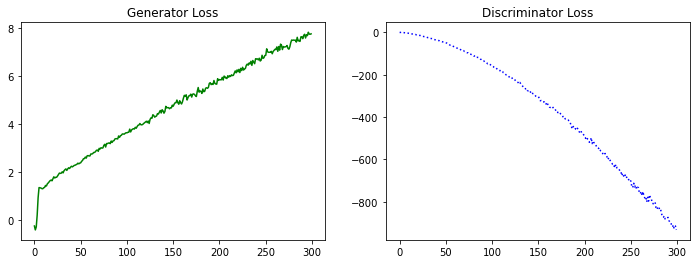

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ctgan.generator_loss,'-g')
ax[0].set_title('Generator Loss')

ax[1].plot(ctgan.discriminator_loss,':b')
ax[1].set_title('Discriminator Loss');

## First Five continuous columns

In [19]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val[list_expnd[0:5]], epochs=300, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  1000
Number of Epochs:  300
training data shape:  (46247, 5)
validation data shape:  (9878, 5)
num_components 12
num_components 13
num_components 14
num_components 15
num_components 14
transformed data shape:  (46247, 73)
data dimension: 73
Dropout rate:  0.5
Epoch 1, Loss G: -0.7370, Loss D: -0.6907
Epoch 2, Loss G: -0.4709, Loss D: 0.7578
Epoch 3, Loss G: 1.1498, Loss D: -1.5565
Epoch 4, Loss G: 2.1317, Loss D: -4.6412
Epoch 5, Loss G: 2.3541, Loss D: -6.5196
Epoch 6, Loss G: 2.5358, Loss D: -8.6719
Epoch 7, Loss G: 2.4474, Loss D: -9.3813
Epoch 8, Loss G: 2.5817, Loss D: -10.9091
Epoch 9, Loss G: 2.9064, Loss D: -14.1991
Epoch 10, Loss G: 2.8610, Loss D: -15.2556
Epoch 11, Loss G: 3.0079, Loss D: -18.3800
Epoch 12, Loss G: 3.0577, Loss D: -20.5617
Epoch 13, Loss G: 3.2940, Loss D: -23.8633
Epoch 14, Loss G: 3.2461, Loss D: -24.8726
Epoch 15, Loss G: 3.3734, Loss D: -28.4393
Epoch 16, Loss G: 3.5548, Loss D: -31.1236
Epoc

Epoch 176, Loss G: 19.7360, Loss D: -1845.0480
Epoch 177, Loss G: 19.6206, Loss D: -1821.9106
Epoch 178, Loss G: 19.8627, Loss D: -1906.8296
Epoch 179, Loss G: 19.9097, Loss D: -1918.1552
Epoch 180, Loss G: 20.5530, Loss D: -1967.4760
Epoch 181, Loss G: 19.8488, Loss D: -1935.8350
Epoch 182, Loss G: 20.3613, Loss D: -1957.9456
Epoch 183, Loss G: 20.2193, Loss D: -1952.4246
Epoch 184, Loss G: 20.4752, Loss D: -2013.7500
Epoch 185, Loss G: 20.3307, Loss D: -1984.6965
Epoch 186, Loss G: 20.3658, Loss D: -2026.2253
Epoch 187, Loss G: 20.5513, Loss D: -2030.1937
Epoch 188, Loss G: 20.5496, Loss D: -2114.6121
Epoch 189, Loss G: 20.8911, Loss D: -2068.8516
Epoch 190, Loss G: 20.4658, Loss D: -2037.3372
Epoch 191, Loss G: 20.6710, Loss D: -2109.3123
Epoch 192, Loss G: 21.3758, Loss D: -2110.4231
Epoch 193, Loss G: 21.1757, Loss D: -2121.7639
Epoch 194, Loss G: 20.9824, Loss D: -2158.9961
Epoch 195, Loss G: 21.0893, Loss D: -2142.9590
Epoch 196, Loss G: 21.0506, Loss D: -2186.5796
Epoch 197, Lo

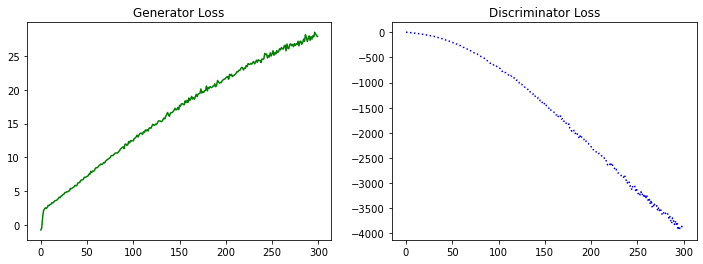

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ctgan.generator_loss,'-g')
ax[0].set_title('Generator Loss')

ax[1].plot(ctgan.discriminator_loss,':b')
ax[1].set_title('Discriminator Loss');

# First Five categorical columns

In [21]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val[cat_cols[0:5]], discrete_columns=cat_cols[0:5], epochs=300, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  1000
Number of Epochs:  300
training data shape:  (46247, 5)
validation data shape:  (9878, 5)
transformed data shape:  (46247, 10)
data dimension: 10
Dropout rate:  0.5
Epoch 1, Loss G: 0.3159, Loss D: 0.1194
Epoch 2, Loss G: 0.3089, Loss D: 0.0486
Epoch 3, Loss G: 0.1753, Loss D: -0.0211
Epoch 4, Loss G: -0.0801, Loss D: -0.0683
Epoch 5, Loss G: -0.2196, Loss D: -0.0584
Epoch 6, Loss G: -0.1605, Loss D: -0.0674
Epoch 7, Loss G: -0.2869, Loss D: -0.1799
Epoch 8, Loss G: -0.3306, Loss D: -0.1106
Epoch 9, Loss G: -0.5521, Loss D: -0.0181
Epoch 10, Loss G: -0.6211, Loss D: 0.0030
Epoch 11, Loss G: -0.6843, Loss D: -0.0330
Epoch 12, Loss G: -0.8838, Loss D: 0.0219
Epoch 13, Loss G: -0.9356, Loss D: 0.1256
Epoch 14, Loss G: -1.0407, Loss D: 0.0663
Epoch 15, Loss G: -1.1789, Loss D: -0.0081
Epoch 16, Loss G: -0.8998, Loss D: 0.0582
Epoch 17, Loss G: -1.1088, Loss D: -0.0416
Epoch 18, Loss G: -1.2461, Loss D: 0.0745
Epoch 19, Los

Epoch 187, Loss G: -0.8662, Loss D: 0.0520
Epoch 188, Loss G: -0.8043, Loss D: 0.0205
Epoch 189, Loss G: -0.9391, Loss D: -0.0842
Epoch 190, Loss G: -0.4637, Loss D: -0.1656
Epoch 191, Loss G: -1.0972, Loss D: -0.0657
Epoch 192, Loss G: -0.7800, Loss D: 0.1292
Epoch 193, Loss G: -0.9892, Loss D: -0.2126
Epoch 194, Loss G: -0.6161, Loss D: -0.2464
Epoch 195, Loss G: -0.5973, Loss D: -0.2286
Epoch 196, Loss G: -0.9466, Loss D: 0.1611
Epoch 197, Loss G: -0.8297, Loss D: -0.1171
Epoch 198, Loss G: -0.9179, Loss D: -0.0869
Epoch 199, Loss G: -0.9647, Loss D: -0.2560
Epoch 200, Loss G: -0.7824, Loss D: 0.2624
Epoch 201, Loss G: -0.8819, Loss D: 0.0318
Epoch 202, Loss G: -0.6277, Loss D: 0.0660
Epoch 203, Loss G: -0.9369, Loss D: -0.0515
Epoch 204, Loss G: -0.6593, Loss D: -0.1706
Epoch 205, Loss G: -1.0882, Loss D: 0.0717
Epoch 206, Loss G: -0.8154, Loss D: 0.0110
Epoch 207, Loss G: -0.8420, Loss D: -0.0531
Epoch 208, Loss G: -0.7045, Loss D: -0.2165
Epoch 209, Loss G: -0.4573, Loss D: -0.16

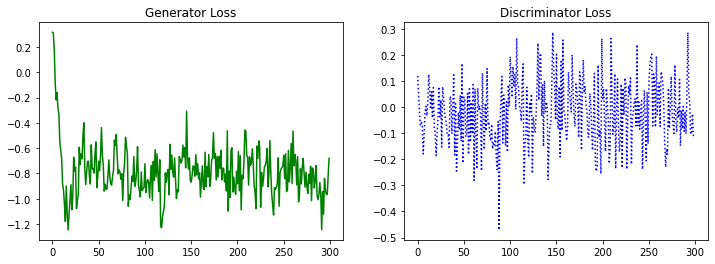

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ctgan.generator_loss,'-g')
ax[0].set_title('Generator Loss')

ax[1].plot(ctgan.discriminator_loss,':b')
ax[1].set_title('Discriminator Loss');

# First Five categorical columns (without cross entropy)

In [17]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val[cat_cols[0:5]], discrete_columns=cat_cols[0:5], epochs=300, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  1000
Number of Epochs:  300
training data shape:  (46247, 5)
validation data shape:  (9878, 5)
transformed data shape:  (46247, 10)
data dimension: 10
Dropout rate:  0.5
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 13, Loss G: -0.6145, Loss D: -0.2890
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 17, Loss G: -0.6420, Loss D: -0.1273
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 30, Loss G: -0.6038, Loss D: -0.0195
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 43, Loss G: -0.5531, Loss D: -0.1528
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 47, Loss G: -0.5060, Loss D: 0.0065
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([100

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 60, Loss G: -0.3857, Loss D: -0.0969
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 64, Loss G: -0.8522, Loss D: -0.0451
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 77, Loss G: -0.5650, Loss D: -0.0882
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 81, Loss G: -0.5341, Loss D: -0.1718
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 94, Loss G: -0.5630, Loss D: -0.1302
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 98, Loss G: -0.6595, Loss D: -0.1069
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 111, Loss G: -0.9856, Loss D: -0.1365
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 115, Loss G: -0.5180, Loss D: -0.0146
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 128, Loss G: -0.5305, Loss D: -0.0855
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 132, Loss G: -0.5407, Loss D: 0.0316
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 145, Loss G: -0.7289, Loss D: 0.1174
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 149, Loss G: -0.7925, Loss D: 0.1554
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 162, Loss G: -0.5734, Loss D: 0.1825
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
Epoch 166, Loss G: -0.5420, Loss D: -0.0301
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 175, Loss 

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 179, Loss G: -0.6335, Loss D: -0.0568
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

Epoch 183, Loss G: -0.5014, Loss D: -0.0889
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 192, Loss G: -0.5403, Loss D: -0.1298
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 196, Loss G: -0.4302, Loss D: -0.0178
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 209, Loss G: -0.6356, Loss D: -0.2279
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 213, Loss G: -0.7313, Loss D: 0.2460
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 226, Loss G: -0.6461, Loss D: -0.1184
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 230, Loss G: -0.6624, Loss D: -0.2792
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 243, Loss G: -1.0248, Loss D: -0.0489
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 247, Loss G: -0.9309, Loss D: -0.1692
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 260, Loss G: -0.7630, Loss D: 0.1845
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 264, Loss G: -0.8245, Loss D: -0.0737
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 277, Loss G: -0.6954, Loss D: -0.2298
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 281, Loss G: -0.6888, Loss D: -0.1039
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 294, Loss G: -0.8296, Loss D: 0.0706
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
Epoch 298, Loss G: -0.8803, Loss D: 0.2048
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([1000])
torch.Size([1000, 5])
torch.Size([10

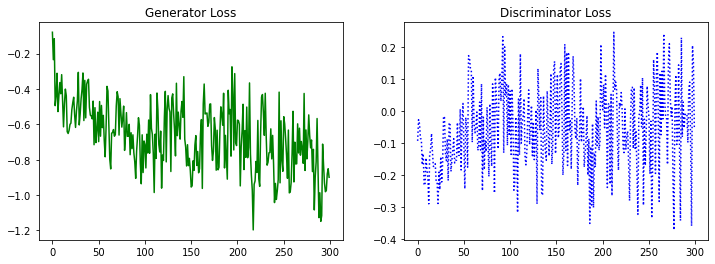

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ctgan.generator_loss,'-g')
ax[0].set_title('Generator Loss')

ax[1].plot(ctgan.discriminator_loss,':b')
ax[1].set_title('Discriminator Loss');

# First five columns

In [23]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val[OVS1618_train_val.columns[0:5]], discrete_columns=cat_cols[0:2],epochs=300, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  1000
Number of Epochs:  300
training data shape:  (46247, 5)
validation data shape:  (9878, 5)
num_components 12
num_components 14
num_components 14
transformed data shape:  (46247, 47)
data dimension: 47
Dropout rate:  0.5
Epoch 1, Loss G: -0.1428, Loss D: 0.0913
Epoch 2, Loss G: -0.2255, Loss D: 0.0874
Epoch 3, Loss G: -0.4507, Loss D: -0.0927
Epoch 4, Loss G: -0.6765, Loss D: 0.0332
Epoch 5, Loss G: -0.6055, Loss D: -0.0545
Epoch 6, Loss G: -0.5229, Loss D: 0.0849
Epoch 7, Loss G: -0.4533, Loss D: 0.0503
Epoch 8, Loss G: -0.2749, Loss D: -0.1449
Epoch 9, Loss G: -0.1730, Loss D: -0.0839
Epoch 10, Loss G: -0.1006, Loss D: -0.1500
Epoch 11, Loss G: -0.0481, Loss D: -0.1283
Epoch 12, Loss G: 0.0759, Loss D: -0.1296
Epoch 13, Loss G: 0.0330, Loss D: -0.1095
Epoch 14, Loss G: -0.0592, Loss D: -0.1300
Epoch 15, Loss G: -0.0733, Loss D: -0.0972
Epoch 16, Loss G: -0.0248, Loss D: -0.0866
Epoch 17, Loss G: 0.0710, Loss D: -0.0605

Epoch 184, Loss G: -0.2439, Loss D: -0.0801
Epoch 185, Loss G: -0.3713, Loss D: -0.0454
Epoch 186, Loss G: -0.2233, Loss D: -0.1419
Epoch 187, Loss G: -0.3417, Loss D: -0.1224
Epoch 188, Loss G: -0.1578, Loss D: -0.0515
Epoch 189, Loss G: -0.2251, Loss D: -0.1368
Epoch 190, Loss G: -0.1697, Loss D: -0.1173
Epoch 191, Loss G: -0.0980, Loss D: -0.1528
Epoch 192, Loss G: -0.2693, Loss D: -0.1696
Epoch 193, Loss G: -0.2435, Loss D: -0.0298
Epoch 194, Loss G: -0.4203, Loss D: -0.0528
Epoch 195, Loss G: -0.2524, Loss D: -0.1170
Epoch 196, Loss G: -0.2996, Loss D: 0.0713
Epoch 197, Loss G: -0.4374, Loss D: 0.0078
Epoch 198, Loss G: -0.3446, Loss D: -0.0156
Epoch 199, Loss G: -0.4838, Loss D: 0.0374
Epoch 200, Loss G: -0.3580, Loss D: -0.0232
Epoch 201, Loss G: -0.4599, Loss D: -0.0251
Epoch 202, Loss G: -0.4093, Loss D: -0.1145
Epoch 203, Loss G: -0.1560, Loss D: 0.0310
Epoch 204, Loss G: -0.2009, Loss D: -0.0448
Epoch 205, Loss G: -0.1148, Loss D: -0.1213
Epoch 206, Loss G: -0.1474, Loss D: 

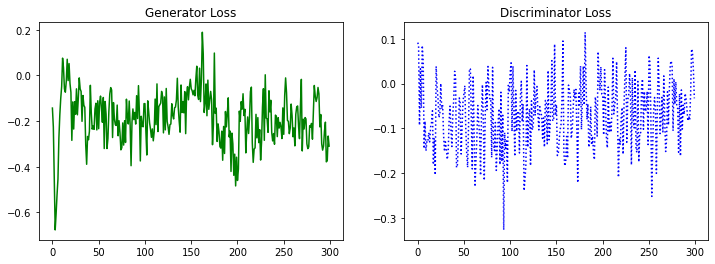

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ctgan.generator_loss,'-g')
ax[0].set_title('Generator Loss')

ax[1].plot(ctgan.discriminator_loss,':b')
ax[1].set_title('Discriminator Loss');

# all benchmark variables

In [25]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=300, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  1000
Number of Epochs:  300
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
num_components 11
num_components 13
num_components 15
num_components 15
num_components 14
num_components 12
num_components 10
num_components 13
num_components 13
num_components 10
num_components 13
num_components 11
num_components 11
num_components 8
transformed data shape:  (46247, 232)
data dimension: 232
Dropout rate:  0.5
Epoch 1, Loss G: -0.6653, Loss D: 0.1114
Epoch 2, Loss G: -0.5119, Loss D: 0.2726
Epoch 3, Loss G: -0.7896, Loss D: -0.2704
Epoch 4, Loss G: -1.6942, Loss D: 0.3781
Epoch 5, Loss G: -1.1063, Loss D: -0.2944
Epoch 6, Loss G: -1.0948, Loss D: -0.1877
Epoch 7, Loss G: -1.3780, Loss D: 0.1310
Epoch 8, Loss G: -1.5289, Loss D: 0.0709
Epoch 9, Loss G: -1.5799, Loss D: 0.1291
Epoch 10, Loss G: -1.5885, Loss D: -0.2583
Epoch 11, Loss G: -1.6051, Loss D: -0.1788
Epoch 12, Loss G: -1.4804, Loss D: -0.2015
Epoch 13, L

Epoch 180, Loss G: -0.8477, Loss D: -0.6032
Epoch 181, Loss G: -0.7326, Loss D: -0.0742
Epoch 182, Loss G: -1.4522, Loss D: 0.2995
Epoch 183, Loss G: -0.7668, Loss D: -0.3139
Epoch 184, Loss G: -0.7849, Loss D: -0.2490
Epoch 185, Loss G: -0.7833, Loss D: 0.1354
Epoch 186, Loss G: -1.0986, Loss D: -0.5746
Epoch 187, Loss G: -1.1856, Loss D: -0.6335
Epoch 188, Loss G: -1.4913, Loss D: -0.4471
Epoch 189, Loss G: -1.6109, Loss D: -0.4096
Epoch 190, Loss G: -1.1344, Loss D: -0.3523
Epoch 191, Loss G: -1.3795, Loss D: -0.0694
Epoch 192, Loss G: -1.1403, Loss D: -0.2467
Epoch 193, Loss G: -1.1685, Loss D: -0.5216
Epoch 194, Loss G: -1.6234, Loss D: -0.1602
Epoch 195, Loss G: -0.9135, Loss D: -0.3458
Epoch 196, Loss G: -1.4916, Loss D: -0.1800
Epoch 197, Loss G: -1.3755, Loss D: -0.6052
Epoch 198, Loss G: -1.5797, Loss D: -0.5097
Epoch 199, Loss G: -1.6428, Loss D: -0.5127
Epoch 200, Loss G: -1.0355, Loss D: -0.3439
Epoch 201, Loss G: -1.5653, Loss D: -0.0735
Epoch 202, Loss G: -1.3026, Loss D

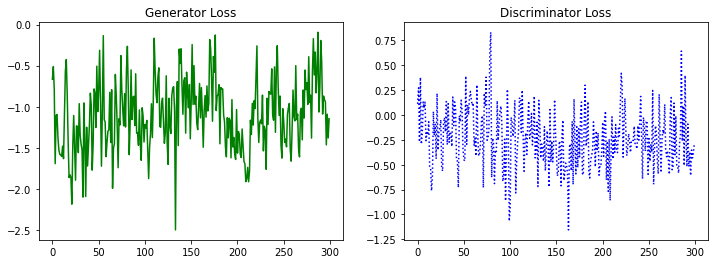

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ctgan.generator_loss,'-g')
ax[0].set_title('Generator Loss')

ax[1].plot(ctgan.discriminator_loss,':b')
ax[1].set_title('Discriminator Loss');